In [1]:
# Standard library imports
import os
import re

# Data handling and numerical processing
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt

# Custom utilities and feature processing
import utils

/opt/miniconda3/envs/FeatureAggregation/lib/python3.8/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [2]:
# Define all dirs
input_dir = Path.cwd().parents[0] / "aws_scripts"
results_root_dir = Path.cwd().parents[0] / "all_LINCS_profiles"

metadata_path = os.path.join(input_dir, 'metadata', 'platemaps', '2016_04_01_a549_48hr_batch1')
file_path = os.path.join(input_dir, "get_data_LINCS.txt")

# Define output dir
output_dir = Path.cwd().parents[0] / "FinalModelResults"

In [3]:
DOSE_POINT = 10

pattern = r'SQ\d{8}'
platenames = []

repurposing_info = pd.read_csv(os.path.join(metadata_path, 'repurposing_info_long.tsv'), index_col=False,
                               low_memory=False, sep='\t', usecols=["broad_id", "pert_iname", "moa"])
repurposing_info = repurposing_info.rename(columns={"broad_id": "broad_sample"})
repurposing_info = repurposing_info.drop_duplicates()

with open(file_path, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            platenames.append(match.group())

barcode_platemap = pd.read_csv(os.path.join(metadata_path, 'barcode_platemap.csv'), index_col=False)

bigdf = []
for i, platestring in enumerate(platenames):
    platemap_name = barcode_platemap[barcode_platemap["Assay_Plate_Barcode"] == platestring]["Plate_Map_Name"].iloc[0]
    C_metadata = pd.read_csv(os.path.join(metadata_path, 'platemap', platemap_name +'.txt'), sep='\t')
    if DOSE_POINT == 10:
        df = C_metadata[np.logical_and(C_metadata['mmoles_per_liter'] > 9, C_metadata['mmoles_per_liter'] < 11)]
    elif DOSE_POINT == 3:
        df = C_metadata[np.logical_and(C_metadata['mmoles_per_liter'] > 2.9, C_metadata['mmoles_per_liter'] < 6)]

    df['plate'] = platestring
    bigdf.append(df)

bigdf = pd.merge(pd.concat(bigdf), repurposing_info, on='broad_sample', how='left')
bigdf = utils.filterData(bigdf, 'negcon', encode='pert_iname', mode='LINCS')
shape1 = bigdf.shape[0]
bigdf.dropna(inplace=True)  # drop all compounds without annotations for pert_iname (and moa)
shape2 = bigdf.shape[0]
print("Removed", shape1-shape2, "wells due to missing annotation of pert_iname and moa.")
bigdf = bigdf[bigdf.Metadata_labels.duplicated(keep=False)]
print("Resulting df shape:", bigdf.shape)

/var/folders/0n/sy07p4_n4jzgg1n5phyn9yq00000gn/T/ipykernel_15901/3225933167.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plate'] = platestring
/var/folders/0n/sy07p4_n4jzgg1n5phyn9yq00000gn/T/ipykernel_15901/3225933167.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['plate'] = platestring
/var/folders/0n/sy07p4_n4jzgg1n5phyn9yq00000gn/T/ipykernel_15901/3225933167.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

Removed 1587 wells due to missing annotation of pert_iname and moa.
Resulting df shape: (5965, 10)


In [4]:
lincs_mlp_profiles = pd.read_csv(os.path.join(results_root_dir, "mlp_profiles_10.csv"))
lincs_average_profiles = pd.read_csv(os.path.join(results_root_dir, "average_profiles_10.csv"))

temp_df = bigdf[['Metadata_labels', 'moa', 'pert_iname', 'plate']][~bigdf.Metadata_labels.duplicated(keep='last')]
temp_df = temp_df.rename(columns={'moa': 'Metadata_moa', 'pert_iname': 'Metadata_pert_iname', 'plate': 'Metadata_plate'})
lincs_mlp_profiles_ann = pd.merge(lincs_mlp_profiles, temp_df, on='Metadata_labels')
lincs_average_profiles_ann = pd.merge(lincs_average_profiles, temp_df, on='Metadata_labels')

print('Dropping ', lincs_mlp_profiles_ann.shape[0] - lincs_mlp_profiles_ann.dropna().reset_index(drop=True).shape[0], 'rows due to NaNs')
lincs_mlp_profiles_ann = lincs_mlp_profiles_ann.dropna().reset_index(drop=True)
lincs_average_profiles_ann = lincs_average_profiles_ann.dropna().reset_index(drop=True)
print('New size:', lincs_mlp_profiles_ann.shape)

Dropping  0 rows due to NaNs
New size: (5922, 2052)


In [5]:
mAP_label = 'Metadata_moa'
ap_mlp = utils.CalculateMAP(lincs_mlp_profiles_ann, 'cosine_similarity',
                        groupby=mAP_label, percent_matching=True)
ap_bm = utils.CalculateMAP(lincs_average_profiles_ann, 'cosine_similarity',
                        groupby=mAP_label, percent_matching=True)

ap_mlp = ap_mlp.groupby('compound').agg({'AP': 'mean'})
ap_bm = ap_bm.groupby('compound').agg({'AP': 'mean'})

/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:336: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=0, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDijk_PLoS_CytoSummaryNet/AllPaperFigures/utils.py:335: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  dist.set_axis(compound_names, axis=1, inplace=True)
/Users/rdijk/Desktop/Revision/FULL_BACKUP/2024_vanDi

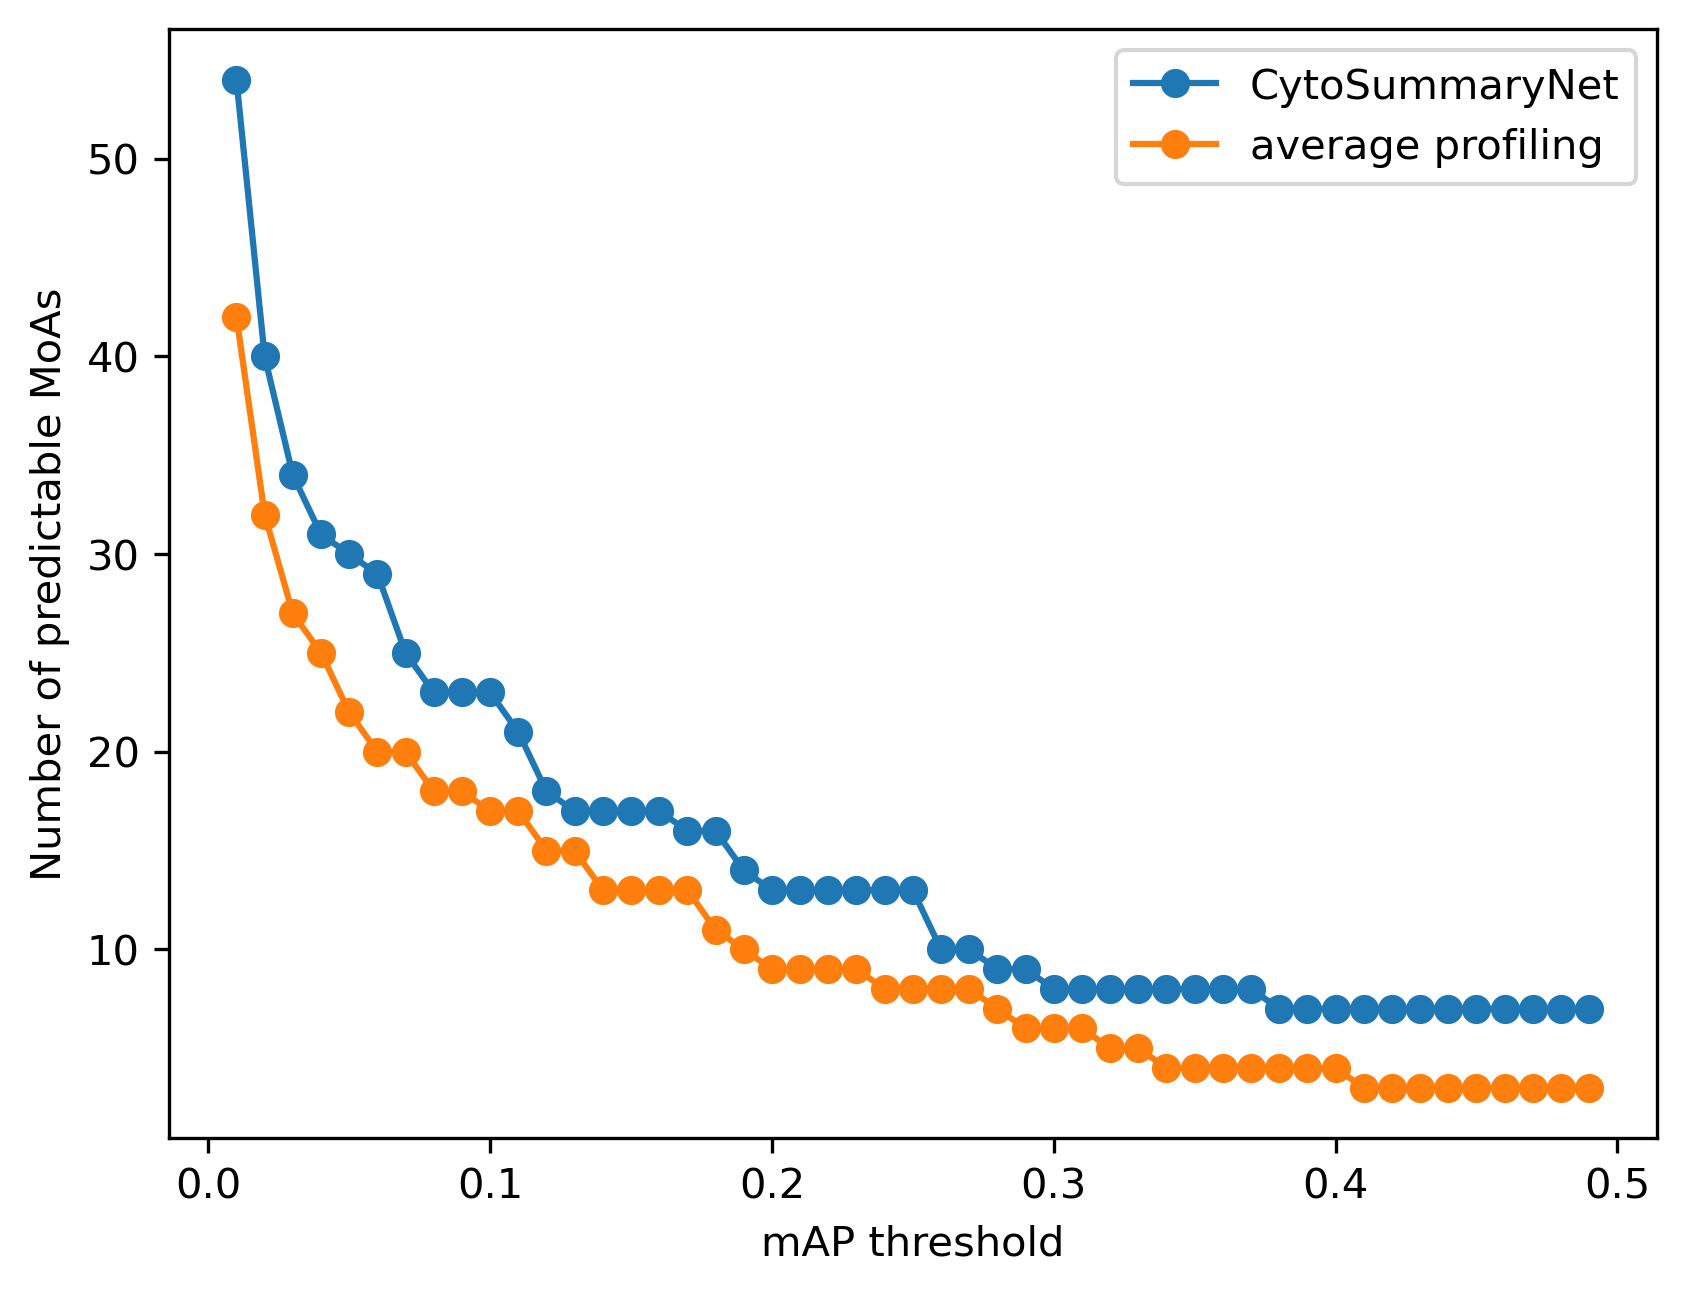

In [6]:
# Define the thresholds
thresholds = np.arange(0.01, 0.5, 0.01)

# Initialize empty lists to store the counts for MLP and BM
counts_mlp = []
counts_bm = []

# Iterate over each threshold
for threshold in thresholds:
    # Count the number of APs above the threshold for MLP
    predictable_mlp = sum(ap_mlp["AP"] >= threshold)
    counts_mlp.append(predictable_mlp)
    
    # Count the number of APs above the threshold for BM
    predictable_bm = sum(ap_bm["AP"] >= threshold)
    counts_bm.append(predictable_bm)

# Create a DataFrame to store the results
threshold_counts_df = pd.DataFrame({'Threshold': thresholds, 'Counts_MLP': counts_mlp, 'Counts_BM': counts_bm})

# Plot the results
plt.figure(dpi=300)
plt.plot(threshold_counts_df['Threshold'], threshold_counts_df['Counts_MLP'], label='CytoSummaryNet', marker='o', linestyle='-')
plt.plot(threshold_counts_df['Threshold'], threshold_counts_df['Counts_BM'], label='average profiling', marker='o', linestyle='-')

# Add labels and title
plt.xlabel('mAP threshold')
plt.ylabel('Number of predictable MoAs')
plt.legend()

# Show the plot
plt.savefig(os.path.join("Figures", 'S1FigJ.png'), dpi=450)
plt.show()